In [2]:
import pandas as pd
import requests
import sys
import logging
import os
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
#import cartoframes
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics

DEBUG:matplotlib:CACHEDIR=/Users/elizabethsaccoccia/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/elizabethsaccoccia/.matplotlib/fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [52]:
# Prepare ACLED 2015 Data
ACLED = pd.read_csv('ACLED_2015_Africa.csv')
#count nulls
ACLED.isnull().sum()
#drop columns with null values
ACLED = ACLED.dropna(axis=0, subset=['notes'])
ACLED_SUM15 = ACLED.country.value_counts()
ACLED_SUM15 = ACLED_SUM15.reset_index()
ACLED_SUM15.rename(columns={'country': '2015_events'}, inplace=True)
ACLED_SUM15.set_index('index', inplace = True)
ACLED_SUM15.head()

,2015_events
index,
Somalia,2356
Nigeria,1672
Burundi,1542
South Africa,1486
Libya,1396


In [53]:
ACLED_SUM15.describe()

,2015_events
count,49.000000
mean,344.081633
std,556.256155
min,1.000000
25%,25.000000
50%,75.000000
75%,362.000000
max,2356.000000


In [7]:
# Prepare ACLED 2016 Data
ACLED16 = pd.read_csv('ACLED_2016_Africa.csv')
#count nulls
ACLED16.isnull().sum()
#drop columns with null values
ACLED16 = ACLED16.dropna(axis=0, subset=['notes'])
ACLED_SUM16 = ACLED16.country.value_counts()
ACLED_SUM16 = ACLED_SUM16.reset_index()
ACLED_SUM16.rename(columns={'country': '2016_events'}, inplace=True)
ACLED_SUM16.set_index('index', inplace = True)
ACLED_SUM16.head()

,2016_events
index,
Somalia,2661
Sudan,1431
South Africa,1418
Nigeria,1402
Ethiopia,1225


[Text(0,0.5,'Number of Events in 2016'), Text(0.5,0,'Countries')]

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000


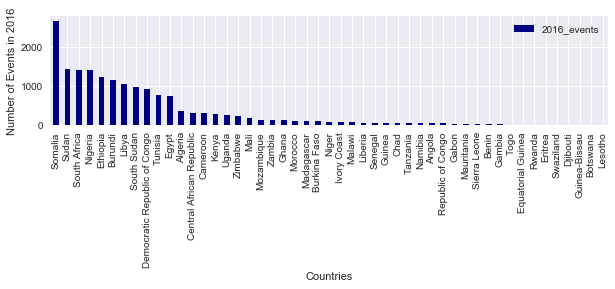

In [8]:
ax = ACLED_SUM16.plot.bar(lw=2, colormap='jet',figsize=(10,2))
ax.set(xlabel='Countries', ylabel="Number of Events in 2016")

In [9]:
ACLED16.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'actor1', 'assoc_actor_1',
       'inter1', 'actor2', 'assoc_actor_2', 'inter2', 'interaction', 'region',
       'country', 'admin1', 'admin2', 'admin3', 'location', 'latitude',
       'longitude', 'geo_precision', 'source', 'source_scale', 'notes',
       'fatalities', 'timestamp', 'iso3'],
      dtype='object')

In [10]:
#Prepare Fragile States Index Data for 2015
fsi = pd.read_csv('soc_023_fragile_states_index.csv')
fsi.drop(fsi.columns[[0, 1, 2]], axis=1, inplace=True)
fsi.rename(columns={'score_data':'fsi'}, inplace=True)
mask = (fsi['datetime'] > 2014) & (fsi['datetime'] <= 2015)
fsi_current = fsi.loc[mask]
prepfsi = fsi_current.drop(['datetime','rank_data', 'rw_country_code'], axis=1)
prepfsi.set_index('rw_country_name', inplace = True)
prepfsi.head()

,fsi
rw_country_name,
Netherlands,26.9
Bolivia,78.1
Greece,52.6
Libya,95.3
Moldova,73.0


In [11]:
#Prepare Water stress Data for 2015
ws = pd.read_csv('wat_036_water_stress_country_ranking.csv')
ws.rename(columns={'wri_name':'rw_country_name','all_sectors': 'water_stress' }, inplace=True)
ws.drop(['cartodb_id','name'], axis=1, inplace = True)
ws.set_index('rw_country_name', inplace = True)
ws.head()

,water_stress
rw_country_name,
Egypt,1.327988
Republic of Serbia,0.583519
Suriname,0.253345
Slovakia,0.197466
Slovenia,0.027711


In [12]:
#Prepare HDI data for 2015
hdi = pd.read_csv('soc_004_human_development_index.csv')
hdi.drop(['cartodb_id', 'rw_country_code', 'datetime'], axis=1, inplace=True)
hdi.rename(columns= {"yr_data" : "HDI"}, inplace=True)
hdi.set_index('rw_country_name', inplace = True)
hdi.head()

,HDI
rw_country_name,
Guinea Bissau,0.424
South Sudan,0.418
Norway,0.949
Iraq,0.649
Kenya,0.555


In [13]:
data = pd.concat([prepfsi, ws, hdi, ACLED_SUM15, ACLED_SUM16], axis=1)
data = data.dropna(axis=0)
data

,fsi,water_stress,HDI,2015_events,2016_events
Algeria,79.6,3.444267,0.745,362.0,361.0
Angola,87.9,1.539987,0.533,15.0,45.0
Benin,78.8,0.000000,0.485,12.0,20.0
Botswana,62.8,1.362974,0.698,4.0,4.0
Burkina Faso,89.2,0.000004,0.402,120.0,105.0
Burundi,98.0,0.000000,0.404,1542.0,1164.0
Cameroon,94.3,0.107044,0.518,135.0,299.0
Central African Republic,111.9,0.000000,0.352,365.0,301.0
Chad,108.4,0.522389,0.396,41.0,48.0
Djibouti,88.0,3.390809,0.473,9.0,5.0


In [14]:
data.shape

(44, 5)

In [15]:
data.corr()

,fsi,water_stress,HDI,2015_events,2016_events
fsi,1.000000,-0.403810,-0.654106,0.245649,0.262577
water_stress,-0.403810,1.000000,0.581673,0.140105,0.117111
HDI,-0.654106,0.581673,1.000000,0.217205,0.170669
2015_events,0.245649,0.140105,0.217205,1.000000,0.925984
2016_events,0.262577,0.117111,0.170669,0.925984,1.000000


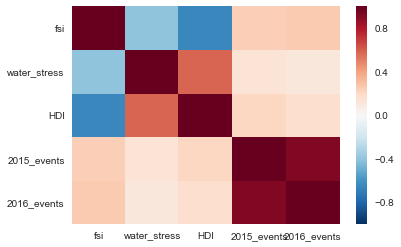

In [16]:
sns.heatmap(data.corr())

In [17]:
feature_cols = ['fsi', 'water_stress', 'HDI', '2015_events']

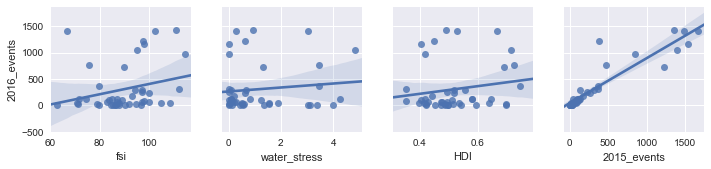

In [18]:
sns.pairplot(data, x_vars=feature_cols, y_vars='2016_events', kind='reg')

# Make a Linear Regression

In [19]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [20]:
# Create X and y.
feature_cols = ['fsi', 'water_stress', 'HDI', '2015_events']
X = data[feature_cols] #feat is list called HDI 
y = data['2016_events']

In [21]:
lr.fit(X, y)
print(lr.coef_)
print(lr.intercept_)

[  1.14436634   2.86602322 -60.57307236   0.84340402]
-29.5809736373


In [22]:
linreg = LinearRegression()
linreg.fit(X, y)
print(linreg.coef_)
print(linreg.intercept_)

[  1.14436634   2.86602322 -60.57307236   0.84340402]
-29.5809736373


In [23]:
# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.total_rentals
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [24]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null

array([ 349.63636364,  349.63636364,  349.63636364,  349.63636364,
        349.63636364,  349.63636364,  349.63636364,  349.63636364,
        349.63636364,  349.63636364,  349.63636364])

In [25]:
# Compute null RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_null))

444.57748536770038

In [26]:
#the mean is better?

# Create a Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

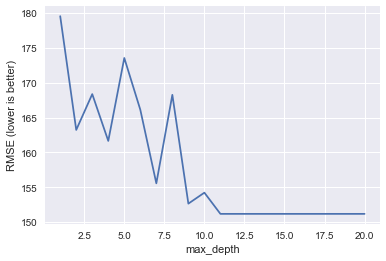

In [28]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [29]:
# Show the best RMSE and the corresponding max_depth.
sorted(zip(RMSE_scores, max_depth_range))[0]

(151.16132384146869, 11)

In [30]:
# max_depth=2 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=6, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [31]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance')

,feature,importance
0,fsi,0.004959
1,water_stress,0.007309
2,HDI,0.057233
3,2015_events,0.930500


In [32]:
# Create a Graphviz file and generate an image of the decision tree# Create 
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_kiva.dot', feature_names=feature_cols)

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
# max_features=5 is best and n_estimators=150 is sufficiently large.
rfreg = RandomForestRegressor(n_estimators=150, max_features=4, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

In [35]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
1,water_stress,0.006294
0,fsi,0.015198
2,HDI,0.021520
3,2015_events,0.956987


In [36]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.794699741948


118.13380389077945

 # Reducing X to its Most Important Features

In [37]:
# Check the shape of X.
X.shape

(44, 4)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 89)

In [39]:
# Fit the model on only the train data
rfreg = RandomForestRegressor(n_estimators=150, max_features=4, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

In [40]:
# Set a threshold for which features to include.
from sklearn.feature_selection import SelectFromModel

print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

(33, 1)
(33, 2)


In [41]:
# Create a new feature matrix that only includes important features.
X_important =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)

In [42]:
# Check the RMSE for a random forest that only includes important features.
rfreg = RandomForestRegressor(n_estimators=150, max_features=1, random_state=1)

scores = cross_val_score(rfreg, X_important, y_test, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

138.82522937787769

In [43]:
# Probably only better because I have such a small sample size

# Now do with ADM-2

In [44]:
#get ACLED16 by ADM2 #this should be turned into a function
AC15_ADM2 = ACLED.admin2.value_counts()
AC15_ADM2.head()
col_list15 = ['admin2', 'country']
clean15 = ACLED[col_list15].copy()
clean15
clean15['Counts15'] = clean15.groupby(['admin2'])['admin2'].transform('count')
clean15.head()
#delete duplicates admin2
clean15.drop_duplicates('admin2', inplace = True)   
clean15.set_index('country', inplace = True)
clean15.sort_values('Counts15', ascending = False).head()

,admin2,Counts15
country,,
Somalia,Mogadisho,492.0
Libya,Benghazi,431.0
South Africa,City of Cape Town,285.0
Egypt,Rafah,256.0
Democratic Republic of Congo,Nord-Kivu,254.0


In [45]:
#get ACLED16 by ADM2
AC16_ADM2 = ACLED16.admin2.value_counts()
AC16_ADM2.head()
col_list16 = ['admin2', 'country']
clean16 = ACLED16[col_list16].copy()
clean16
clean16['Counts16'] = clean16.groupby(['admin2'])['admin2'].transform('count')
clean16.head()
#delete duplicates admin2
clean16.drop_duplicates('admin2', inplace = True)   
clean16.set_index('country', inplace = True)
clean16.sort_values('Counts16', ascending = False).head()

,admin2,Counts16
country,,
Somalia,Mogadisho,541.0
Libya,Benghazi,343.0
South Africa,City of Cape Town,302.0
Democratic Republic of Congo,Nord-Kivu,269.0
Libya,Surt,238.0


In [46]:
#merge ACLED data
totACLED = pd.merge(clean15, clean16, on=['admin2'],left_index=True )
totACLED.sort_values('Counts15', ascending = False).head()

,admin2,Counts15,Counts16
country,,,
Somalia,Mogadisho,492.0,541.0
Libya,Benghazi,431.0,343.0
South Africa,City of Cape Town,285.0,302.0
Egypt,Rafah,256.0,170.0
Democratic Republic of Congo,Nord-Kivu,254.0,269.0


In [47]:
# Merge with other based on countries
ADM2data = pd.merge(totACLED,data, how='inner', left_index=True, right_index=True)
ADM2data.sort_values('Counts16', ascending = False).head()
ADM2data.head()

,admin2,Counts15,Counts16,fsi,water_stress,HDI,2015_events,2016_events
Algeria,Biskra,2.0,12.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Batna,7.0,5.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Constantine,9.0,13.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Oran,14.0,18.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Azzefoun,2.0,2.0,79.6,3.444267,0.745,362.0,361.0


In [48]:
#fGet rid of columns
#ADM2data.drop([8,9], axis=1)
#del ADM2data['country']
#del ADM2data['Counts']
ADM2data.head()

,admin2,Counts15,Counts16,fsi,water_stress,HDI,2015_events,2016_events
Algeria,Biskra,2.0,12.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Batna,7.0,5.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Constantine,9.0,13.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Oran,14.0,18.0,79.6,3.444267,0.745,362.0,361.0
Algeria,Azzefoun,2.0,2.0,79.6,3.444267,0.745,362.0,361.0


In [49]:
#fill in missing values for Counts15 and Counts16
ADM2data.Counts15.fillna(value=0, inplace = True)
ADM2data.Counts16.fillna(value=0, inplace = True)
#delete anything else that has something missing
ADM2data.dropna(axis=0, inplace = True)
ADM2data.isnull().sum()

admin2          0
Counts15        0
Counts16        0
fsi             0
water_stress    0
HDI             0
2015_events     0
2016_events     0
dtype: int64

In [51]:
ADM2data.Counts15.describe()

count    1130.000000
mean       10.984071
std        25.616953
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       431.000000
Name: Counts15, dtype: float64

[Text(0,0.5,'Number of Events in 2016'), Text(0.5,0,'admin2')]

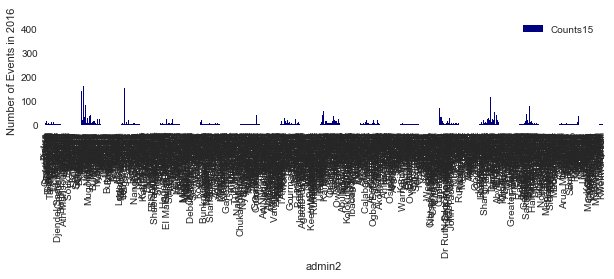

In [50]:
#Graph it
#ax = ADM2data.plot.bar(x='admin2', y='Counts15', lw=2, colormap='jet',figsize=(10,2))
#ax.set(xlabel='admin2', ylabel="Number of Events in 2016")

# Random Forest ADM-2

In [196]:
from sklearn.ensemble import RandomForestRegressor

In [197]:
#Reassign X and Y
feature_cols = ['fsi', 'water_stress', 'HDI', 'Counts15']
X = ADM2data[feature_cols] #feat is list called HDI 
y = ADM2data['Counts16']

In [198]:
# max_features=5 is best and n_estimators=150 is sufficiently large.
rfreg = RandomForestRegressor(n_estimators=150, max_features=4, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

In [200]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
1,water_stress,0.043394
0,fsi,0.044536
2,HDI,0.069642
3,Counts15,0.842428


In [201]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.673463411868


14.399157561323685